In [13]:
import sys
sys.path.append('../')

import jax
# set jax precision 64 bit
jax.config.update("jax_enable_x64", True)

from jax import vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt
from src.training import train_model, make_batches
from flax import linen as nn

In [14]:
class MultiHeadSelfAttention(nn.Module):
    embed_dim: int
    num_heads: int

    def setup(self):
        assert self.embed_dim % self.num_heads == 0, "Embedding dimension must be divisible by the number of heads."
        self.head_dim = self.embed_dim // self.num_heads
        self.qkv_proj = nn.Dense(self.embed_dim * 3, use_bias=False)  # For Query, Key, Value
        self.out_proj = nn.Dense(self.embed_dim)

    def __call__(self, x, mask=None):
        seq_len, input_dim = x.shape
        
        if mask is None:
            mask = jnp.ones((seq_len,))
        
        qkv = self.qkv_proj(x)  # Shape: (batch_size, seq_len, embed_dim * 3)
        qkv = qkv.reshape(seq_len, 3, self.num_heads, self.head_dim)
        q, k, v = jnp.split(qkv, 3, axis=1)  # Each: (batch_size, seq_len, num_heads, head_dim)
        q, k, v = q.squeeze(1), k.squeeze(1), v.squeeze(1)

        # Compute attention weights
        attn_weights = jnp.einsum("qhd,khd->hqk", q, k) / jnp.sqrt(self.head_dim)
        attn_weights = jnp.where(mask[None, None, :], attn_weights, -1e9)
        attn_weights = jax.nn.softmax(attn_weights, axis=-1)
        attn_weights = jnp.where(mask[None, :, None], attn_weights, 0.)
        
        # Compute attention output
        attn_output = jnp.einsum("hqk,khd->qhd", attn_weights, v)
        attn_output = attn_output.reshape(seq_len, self.embed_dim)
        return self.out_proj(attn_output)


class TransformerEncoderLayer(nn.Module):
    embed_dim: int
    num_heads: int

    def setup(self):
        self.attention = MultiHeadSelfAttention(self.embed_dim, self.num_heads)
        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()
        self.feed_forward = nn.Sequential([
            nn.Dense(self.embed_dim),
            nn.gelu,
            nn.Dense(self.embed_dim),
        ])

    def __call__(self, x, mask=None):
        if mask is None:
            mask = jnp.ones((x.shape[0],))
        attn_out = self.attention(x, mask)
        x = self.norm1(x + attn_out)
        ff_out = self.feed_forward(x)
        x = self.norm2(x + ff_out)
        return jnp.where(mask[:, None], x, 0.)


class Model(nn.Module):
    embed_dim: int
    num_heads: int
    
    
    def setup(self):
        self.embedding = nn.Sequential([
            nn.Dense(self.embed_dim),
            nn.gelu,
            nn.Dense(self.embed_dim),
            nn.gelu,
            nn.Dense(self.embed_dim),
        ])
        self.multihead = TransformerEncoderLayer(self.embed_dim, self.num_heads)
        self.multihead2 = TransformerEncoderLayer(self.embed_dim, self.num_heads)
        self.multihead3 = TransformerEncoderLayer(self.embed_dim, self.num_heads)
        self.lin = nn.Dense(1)
        
    def __call__(self, x, mask=None):
        y = self.embedding(x)
        y = self.multihead(y, mask)
        y = self.multihead2(y, mask)
        #y = self.multihead3(y, mask)
        #y = y.flatten() #x = self.lin(x) #return self.lin(x)# + jnp.sum(x)
        return jnp.sum(self.lin(y)) / x.shape[1] #+ jnp.sum(x) #self.lin(x) #jnp.sum(x)

In [15]:
key = jax.random.PRNGKey(0)

data_dir = "/home/emastr/moment-constrained-cryo-em/project_2/data/"
#data = jnp.load(f"{data_dir}/train_data_dens_dom.npy", allow_pickle=True).item()
data = jnp.load(f"{data_dir}/train_data_dens.npy", allow_pickle=True).item()


x_train_pad = data["x"]
mask_train_pad = data["mask"]
y_train_pad = data["y"]

x_train_pad_std = jnp.std(x_train_pad, axis=(0,1))
x_train_pad_mean = jnp.mean(x_train_pad, axis=(0,1))
x_train_pad = (x_train_pad - x_train_pad_mean) / x_train_pad_std

y_train_pad_std = jnp.std(y_train_pad)
y_train_pad_mean = jnp.mean(y_train_pad)
y_train_pad = (y_train_pad - y_train_pad_mean) / y_train_pad_std


# MODEL
num_data, seq_len, token_dim = x_train_pad.shape

num_epochs= 2000
num_heads = 16
embed_dim = 64

key = jax.random.PRNGKey(0)
model = Model(embed_dim, num_heads)#, dropout_rate)
params = model.init(key, x_train_pad[0], mask_train_pad[0])

x_test = x_train_pad[0]
mask_test = mask_train_pad[0]

# Test 1: Invariance to shuffling of sequences
idx_seq = jnp.arange(seq_len)
idx_seq = jax.random.permutation(key, idx_seq, axis=0)
x_test_shuffled = x_test[idx_seq]
mask_test_shuffled = mask_test[idx_seq]
print(model.apply(params, x_test, mask_test) - model.apply(params, x_test_shuffled, mask_test_shuffled))

# Test 2: Invariance to values of masked tokens
mask_test_pert = mask_test.at[-1].set(0)
x_test_pert = x_test.at[-1].set(x_test[0])
print(model.apply(params, x_test, mask_test_pert) - model.apply(params, x_test_pert, mask_test_pert))

-5.551115123125783e-17
0.0


In [ ]:
mx_err = lambda x,y: jnp.max(jnp.abs(x-y))
l1_err = lambda x,y: jnp.mean(jnp.abs(x-y))
l2_err = lambda x,y: jnp.mean((x-y)**2)
norm_err = lambda err_fcn, y_apx, y_tru, y_ref: err_fcn(y_apx, y_tru) / err_fcn(y_ref, y_tru)

model_vmap = vmap(model.apply, (None, 0, 0))
loss_fcn = lambda param, x, mask, y: l2_err(model_vmap(param, x, mask).squeeze(), y)

def metrics(par):
    y_apx = vmap(model.apply, (None, 0, 0))(par, x_train_pad, mask_train_pad).squeeze()
    y_ref = jnp.mean(y_train_pad)
    y_tru = y_train_pad
    
    mxerr = norm_err(mx_err, y_apx, y_tru, y_ref)
    l1err = norm_err(l1_err, y_apx, y_tru, y_ref)
    l2err = norm_err(l2_err, y_apx, y_tru, y_ref) ** 0.5
    return {"max": mxerr, "l1": l1err, "l2": l2err}

def dict2str(d):
    return ", ".join([f"{k}: {v:.2e}" for k,v in d.items()])

losslist =  []
for epoch in range(1000):
    key, subkey = jax.random.split(key)
    batches = make_batches(subkey, x_train_pad, y_train_pad, mask_train_pad, batch_size=16)
    for x_data, y_data, mask_data in batches:
        loss, grads = jax.value_and_grad(loss_fcn)(params, x_data, mask_data, y_data)
        params = jax.tree.map(lambda p, g: p - 1e-2*g, params, grads)
        losslist.append(loss)
        print(f"loss: {loss:.2e}. Metrics: " + dict2str(metrics(params)), end='\r')
#params, avg_losses, max_losses, min_losses  = train_model(key, model, x_train_pad, y_train_pad, mask_train_pad, batch_size, num_epochs, 1e-3)

jnp.save(f"{data_dir}/state_embed", {"params": params, "losses": losslist}, allow_pickle=True)
params2 = jnp.load(f"{data_dir}/params_embed.npy", allow_pickle=True).item()

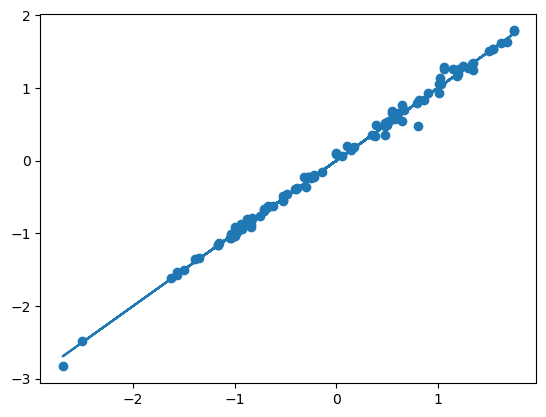

In [ ]:
# Training observations:
# - Loss is choppy (shoots back up and then down)
# - Stays at 0.1
# - Model should be able to fit the data

# Next steps:
# - Try to overfit a simple function (1. everywhere worked)
# - Try to overfit on a small data set ()
# - 

# * Super important for learning: Do not use bias in the QKV formulation??? 
# * Super important for learning: Normalize the data before feeding to model <- incredible how following ML research makes such a big difference
# * Squeeze relevant dimensions to avoid broadcasting error
# * 
jnp.save(f"{data_dir}/params_embed", params, allow_pickle=True)
params2 = jnp.load(f"{data_dir}/params_embed.npy", allow_pickle=True).item()
y_data_est = vmap(model.apply, (None, 0, 0))(params2, x_train_pad, mask_train_pad).squeeze()
plt.scatter(y_data_est, y_train_pad)
plt.plot(y_data_est, y_data_est)




{'num_points': 1000, 'center_x': 0.5, 'width': 1.0, 'ratio': 0.3, 'max_points': 1} 1000 (50, 66)
{'num_points': 1000, 'center_x': 0.5, 'width': 1.0, 'ratio': 0.3, 'max_points': 1} 1000 (50, 66)
(1000, 61, 66)


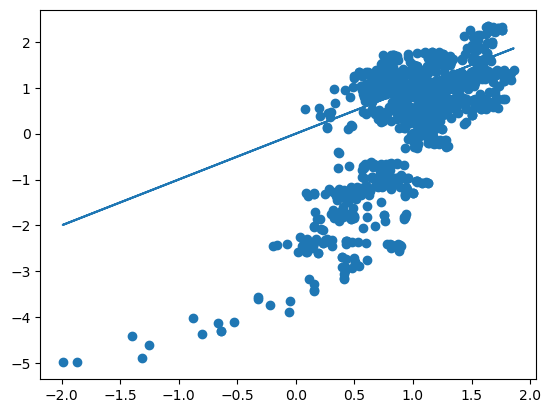

In [ ]:
raw_data = jnp.load(f'{data_dir}/raw_data.npy', allow_pickle=True).item()
print(raw_data["info"], len(raw_data["data"]), raw_data["data"][0][0].shape)

raw_data = jnp.load(f'{data_dir}/raw_data_2.npy', allow_pickle=True).item()
print(raw_data["info"], len(raw_data["data"]), raw_data["data"][0][0].shape)


data = jnp.load(f"{data_dir}/train_data_dens_2.npy", allow_pickle=True).item()


X = data["x"]
M = data["mask"]
Y = data["y"]

print(X.shape)

X_std = x_train_pad_std #jnp.std(X, axis=(0,1))
X_mean = x_train_pad_mean #jnp.mean(X, axis=(0,1))
X = (X - X_mean) / X_std

Y_std = y_train_pad_std #jnp.std(Y)
Y_mean = y_train_pad_mean #jnp.mean(Y)
Y = (Y - Y_mean) / Y_std

Y_est = vmap(model.apply, (None, 0, 0))(params2, X, M).squeeze()
plt.scatter(Y_est, Y)
plt.plot(Y_est, Y_est)



In [8]:
# Training observations:
# - Loss is choppy (shoots back up and then down)
# - Stays at 0.1
# - Model should be able to fit the data

# Next steps:
# - Try to overfit a simple function (1. everywhere worked)
# - Try to overfit on a small data set ()
# - 

# * Super important for learning: Do not use bias in the QKV formulation??? 
# * Super important for learning: Normalize the data before feeding to model <- incredible how following ML research makes such a big difference
# * Squeeze relevant dimensions to avoid broadcasting error
# * 